# NO2 and GDP Analysis

## Library

In [1]:
from pathlib import Path

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import shap
import numpy as np

import warnings

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(label: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in label:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels

## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Enhanced Vegetation Index (EVI) Data: Derived from MODIS satellite imagery

In [3]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

In [4]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

In [5]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(-1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(-2),
    )
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [6]:
no2_adm3_raw = pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv").rename(
    columns={"start_date": "date"}
)
no2_industrial_raw = pd.read_csv(
    DATA_PATH / "AirPollution" / "myanmar_no2_industrial_zones.csv"
)

no2_adm3 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm3_en": "adm3_name"})
    .groupby(["adm3_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm1 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm0 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

For Agriculture GDP does not take into account livestock, fisheries, and forestry.

In [7]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "date"])
    .groupby("sub_group")
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
        )
    )
    .reset_index(drop=True)
    .set_index(["sub_group", "date"])
)

gdp_mft_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Industry"')
    .rename(
        columns={
            "gdp": "gdp_mft",
            "gdp_lag_1": "gdp_mft_lag_1",
            "gdp_lag_2": "gdp_mft_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_svc_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Services"')
    .rename(
        columns={
            "gdp": "gdp_svc",
            "gdp_lag_1": "gdp_svc_lag_1",
            "gdp_lag_2": "gdp_svc_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_mft_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_mft_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_mft_quarterly_adm1 = (
    gdp_mft_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_mft_quarterly.reset_index(), on="date", how="left")
    .rename(
        columns={
            "gdp_mft": "gdp_mft_total",
            "gdp_mft_lag_1": "gdp_mft_lag_1_total",
            "gdp_mft_lag_2": "gdp_mft_lag_2_total",
        }
    )
    .assign(
        gdp_mft=lambda df: df["gdp_mft_total"] * df["industry_pct"],
        gdp_mft_lag_1=lambda df: df["gdp_mft_lag_1_total"] * df["industry_pct"],
        gdp_mft_lag_2=lambda df: df["gdp_mft_lag_2_total"] * df["industry_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp_mft", "gdp_mft_lag_1", "gdp_mft_lag_2"])
)

In [8]:
gdp_quarterly_complete = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", "economic_activity", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "economic_activity", "date"])
    .groupby(["sub_group", "economic_activity"])
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
        )
    )
    .reset_index(drop=True)
    .set_index(["sub_group", "economic_activity", "date"])
)

## NO2

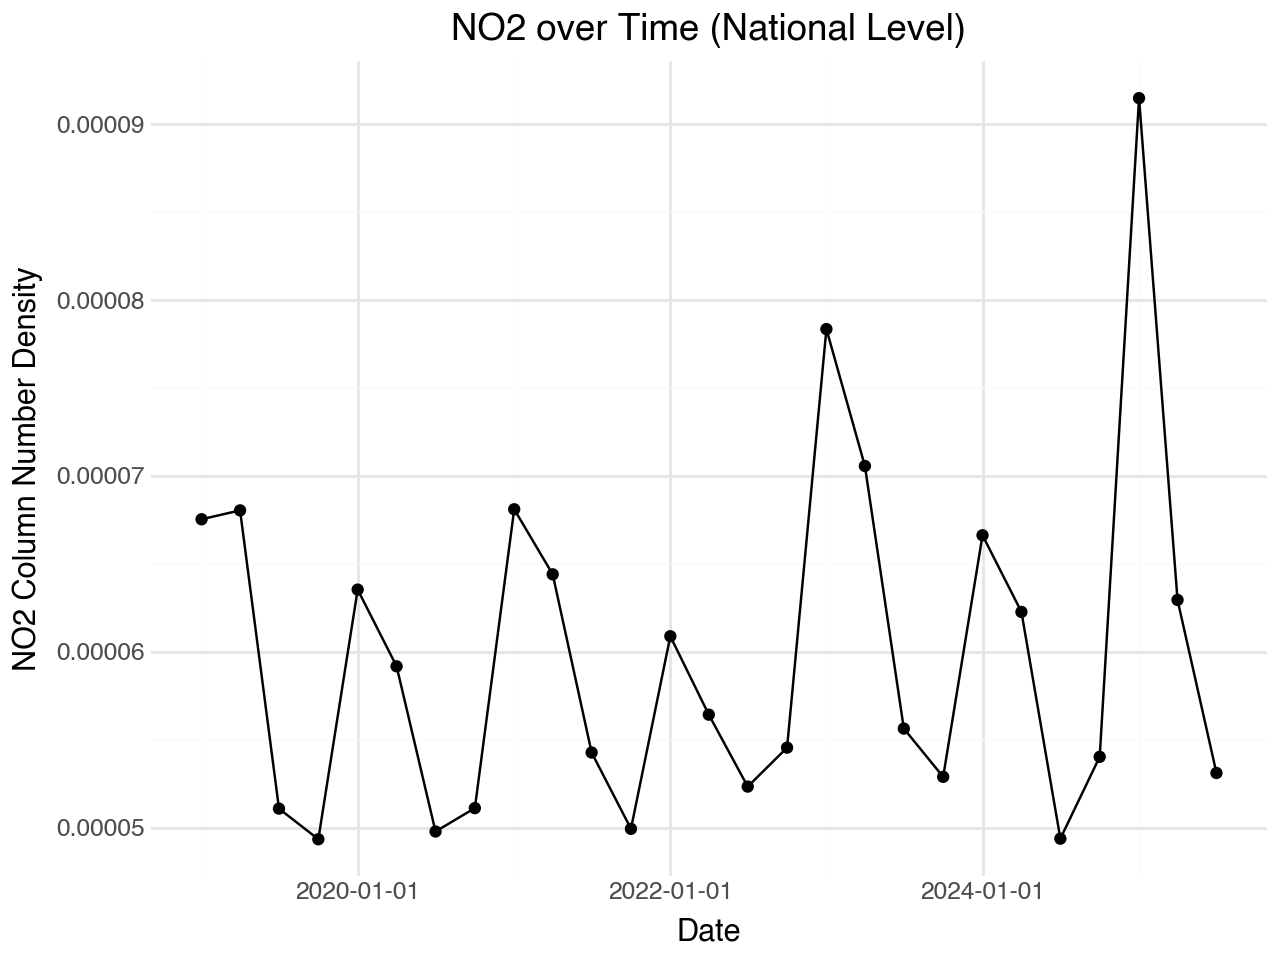

In [9]:
(
    no2_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="no2")
    + p9.geom_point()
    + p9.geom_line()
    # + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="NO2 over Time (National Level)",
        x="Date",
        y="NO2 Column Number Density",
    )
    + p9.theme_minimal()
)

### Admin Level 0

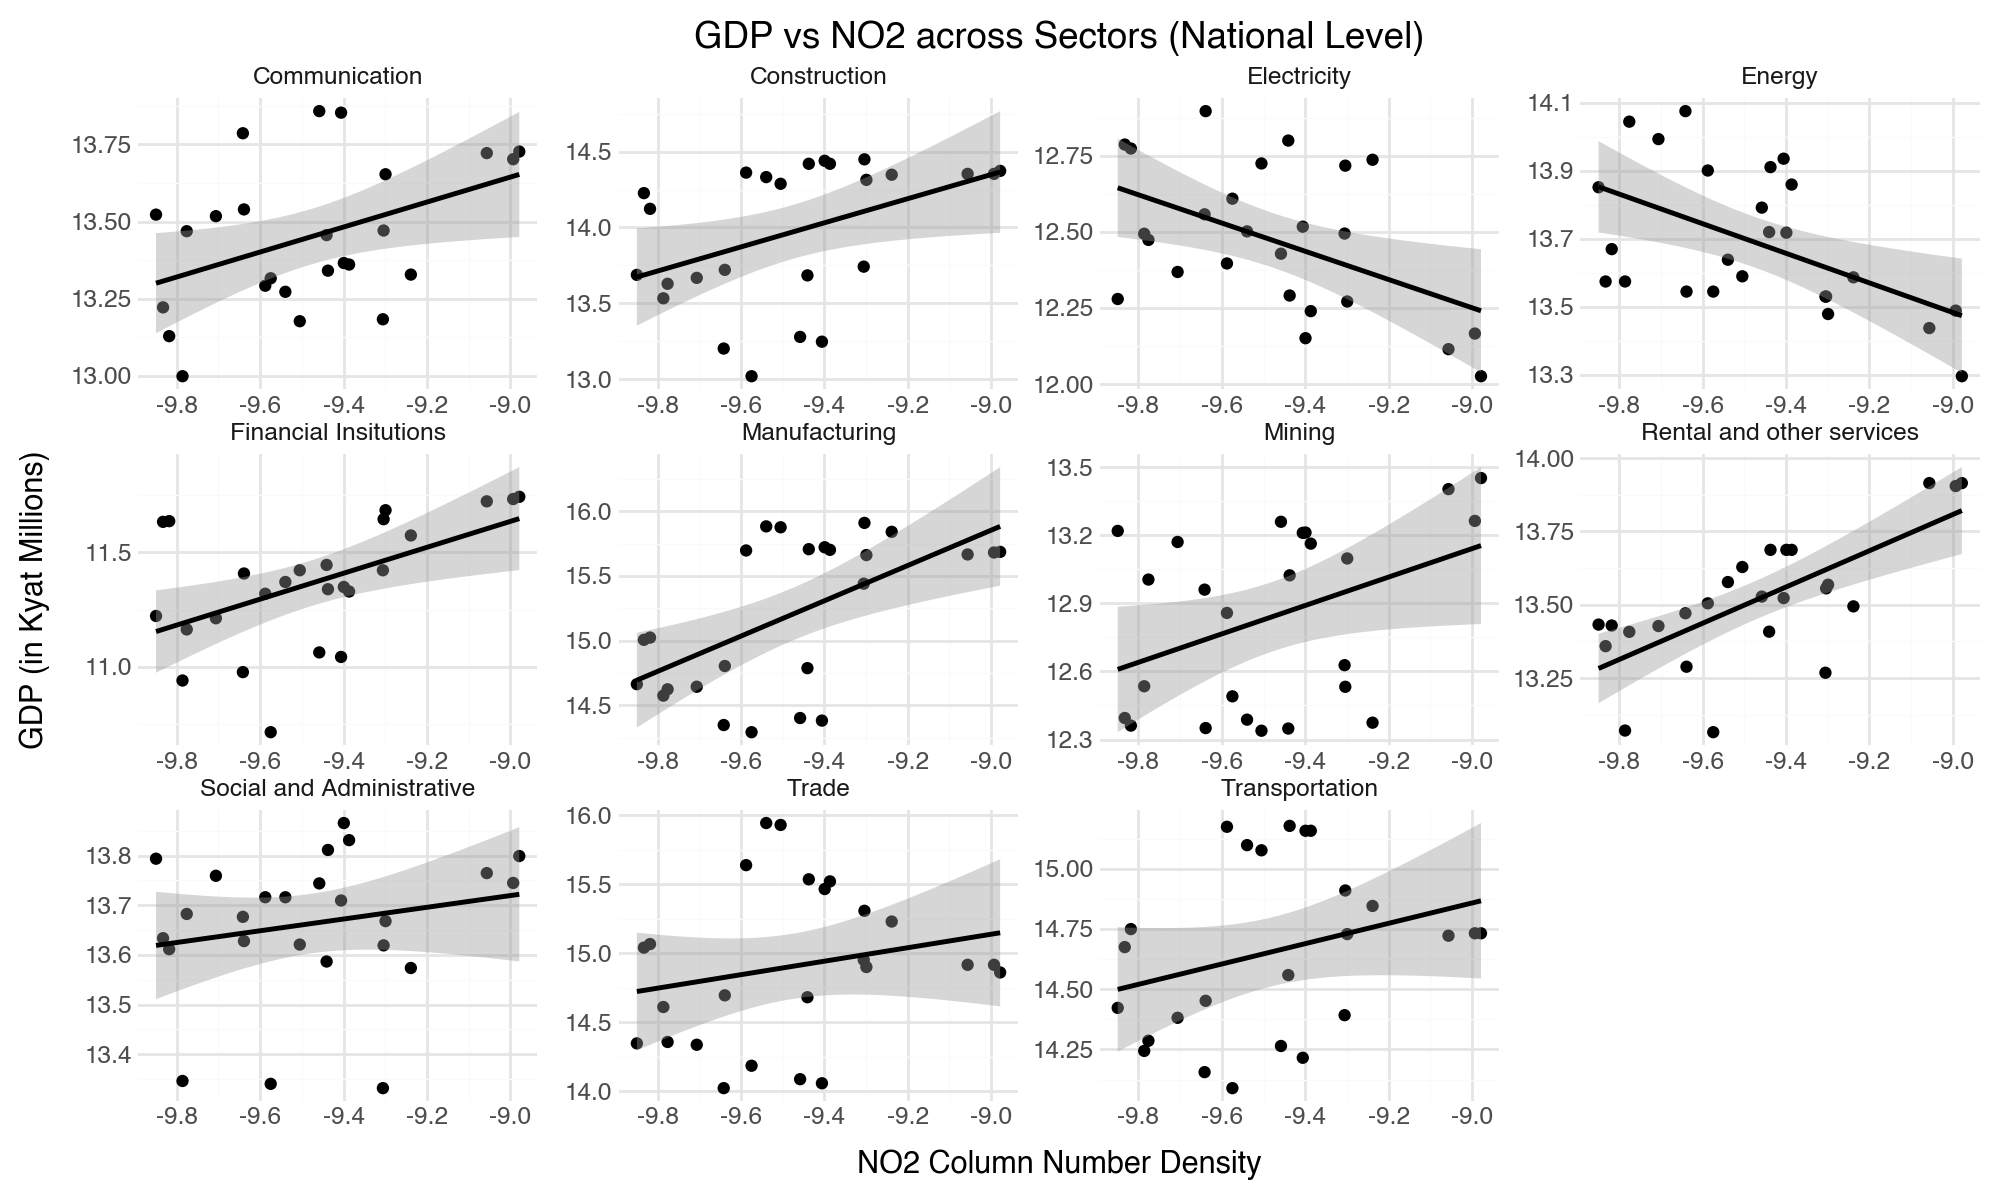

In [10]:
(
    gdp_quarterly_complete.reset_index()
    .merge(
        no2_adm1.reset_index()
        .query("adm1_name == ['Yangon']")
        # .query("adm1_name == ['Mandalay', 'Yangon', 'Sagaing']")
        .groupby("date")
        .agg({"no2": "mean"})
        .reset_index(),
        on="date",
    )
    # .merge(no2_adm0.reset_index(), on="date")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
    .query('sub_group != "Agriculture"')
    .assign(
        gdp_log=lambda df: np.log(df["gdp"]),
        no2_log=lambda df: np.log(df["no2"]),
        no2_lag_1_log=lambda df: np.log(df["no2_lag_1"]),
        no2_lag_2_log=lambda df: np.log(df["no2_lag_2"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("economic_activity", scales="free", ncol=4)
    + p9.labs(
        title="GDP vs NO2 across Sectors (National Level)",
        x="NO2 Column Number Density",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(10, 6))
)

In [20]:
no2_indicators = (
    gdp_mft_quarterly.join(no2_adm0, how="left")
    .join(gdp_svc_quarterly, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
)
no2_indicators.tail()

,gdp_mft,gdp_mft_lag_1,gdp_mft_lag_2,no2,gdp_svc,gdp_svc_lag_1,gdp_svc_lag_2,ntl_mean,ntl_sum,ntl_sum_lag_1,ntl_sum_lag_2,no2_lag_1,no2_lag_2,no2_std,ntl_mean_std,no2_lag_1_std,no2_lag_2_std
date,,,,,,,,,,,,,,,,,
2024-01-01,9.600970e+06,1.019290e+07,5.106123e+06,0.000067,8.571614e+06,1.194872e+07,5.884851e+06,0.082295,1.102821e+06,1.085608e+06,1.217865e+06,0.000053,0.000056,0.650694,0.395872,-0.739904,-0.414237
2024-04-01,4.181992e+06,9.600970e+06,1.019290e+07,0.000062,5.666039e+06,8.571614e+06,1.194872e+07,0.114350,1.085608e+06,1.217865e+06,6.640315e+05,0.000067,0.000053,0.218089,1.781235,0.991350,-0.755570
2024-07-01,5.017848e+06,4.181992e+06,9.600970e+06,0.000049,6.016582e+06,5.666039e+06,8.571614e+06,0.130503,1.217865e+06,6.640315e+05,6.369433e+05,0.000062,0.000067,-1.061160,2.479348,0.441926,0.952487
2024-10-01,1.023193e+07,5.017848e+06,4.181992e+06,0.000054,1.169164e+07,6.016582e+06,5.666039e+06,0.066086,6.640315e+05,6.369433e+05,1.197890e+06,0.000049,0.000062,-0.599415,-0.304624,-1.182759,0.410425
2025-01-01,9.689597e+06,1.023193e+07,5.017848e+06,0.000091,8.474285e+06,1.169164e+07,6.016582e+06,0.063375,6.369433e+05,1.197890e+06,9.006716e+05,0.000054,0.000049,3.117031,-0.421787,-0.596329,-1.192493


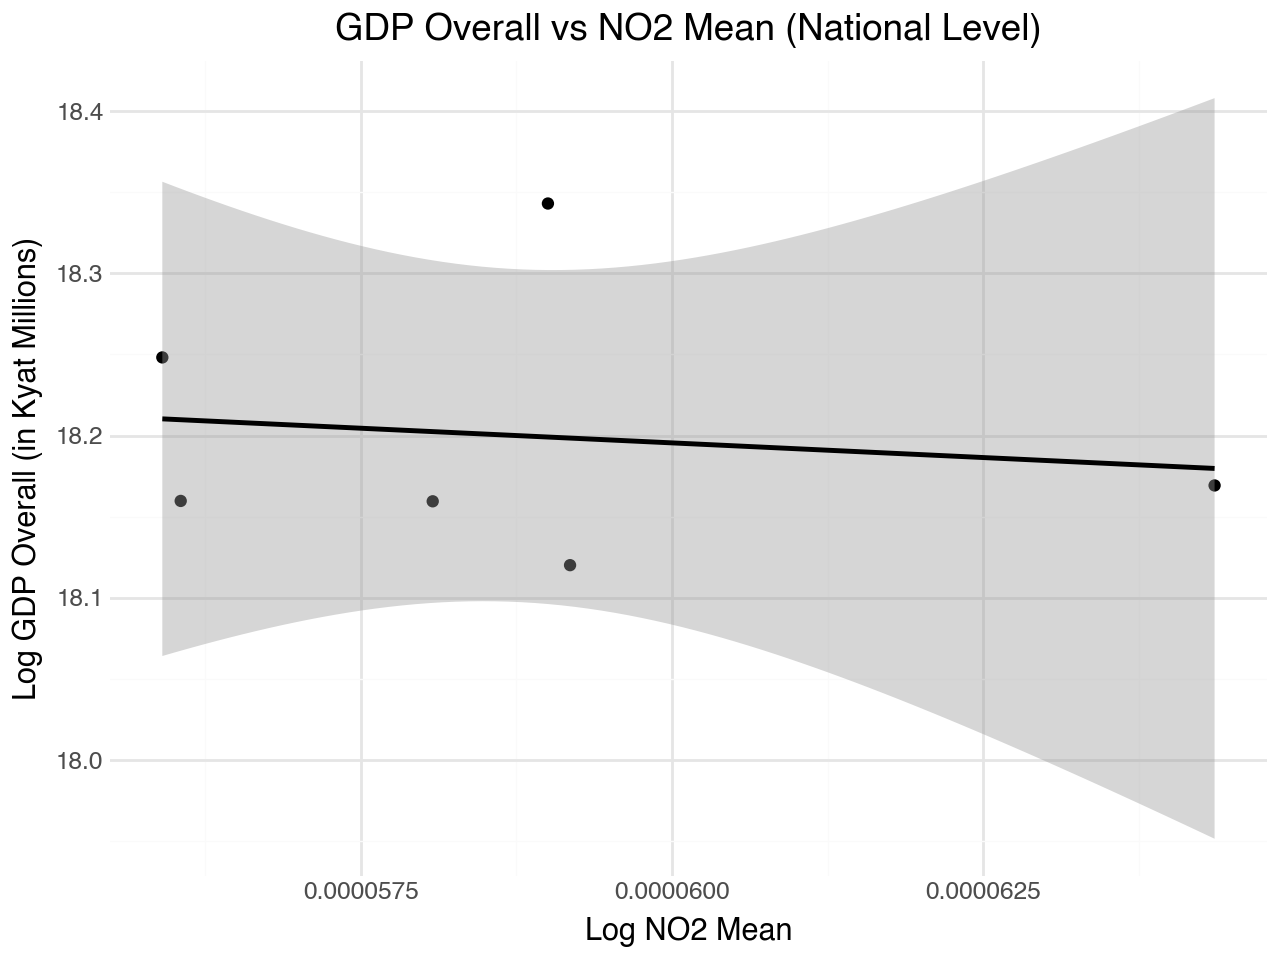

In [12]:
no2_adm0_annual = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="YS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

(
    no2_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NO2 Mean (National Level)",
        x="Log NO2 Mean",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

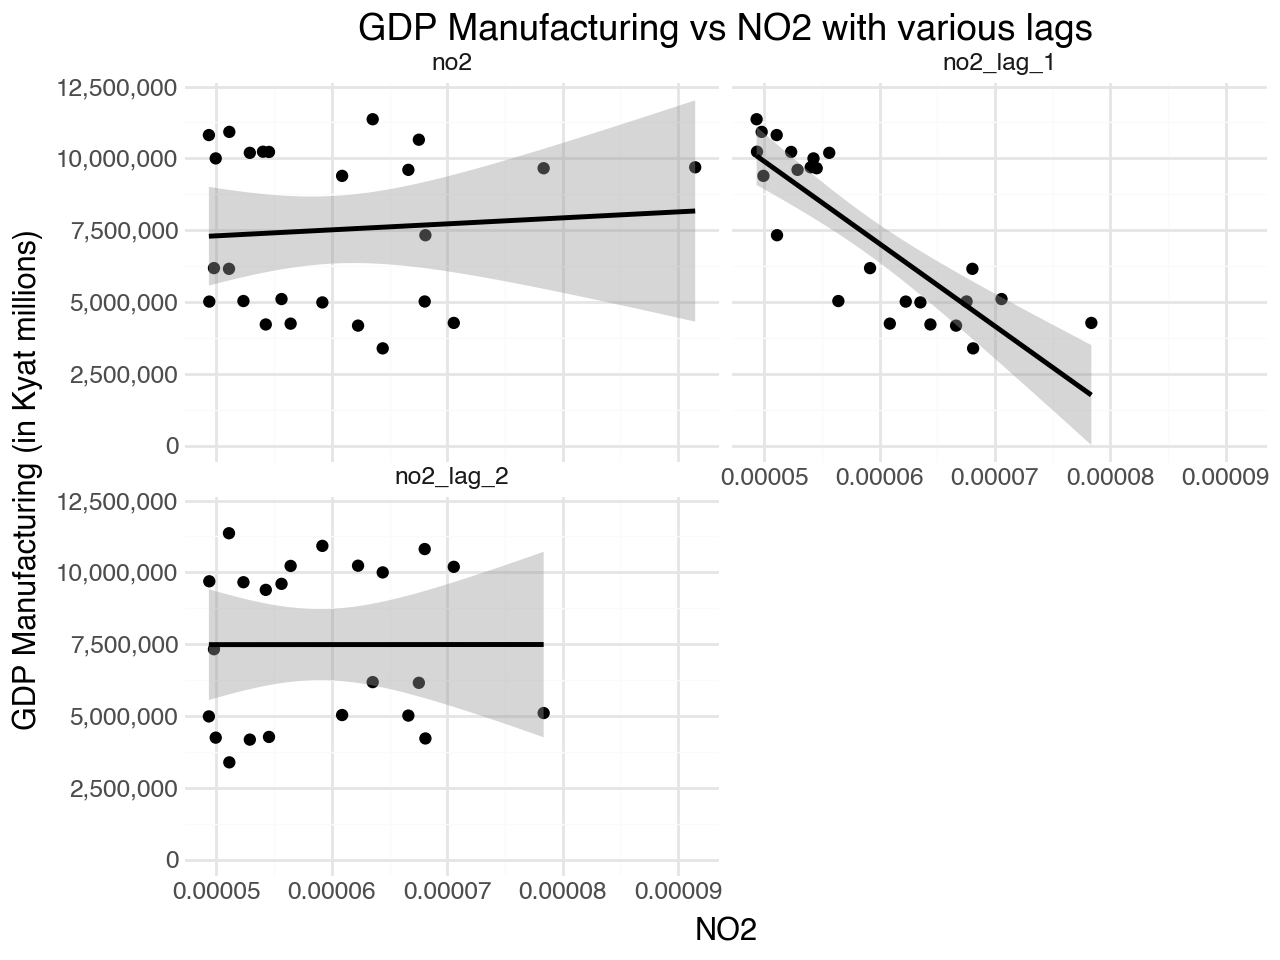

In [13]:
(
    no2_indicators.filter(["gdp_mft", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_mft", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Manufacturing vs NO2 with various lags",
        x="NO2",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

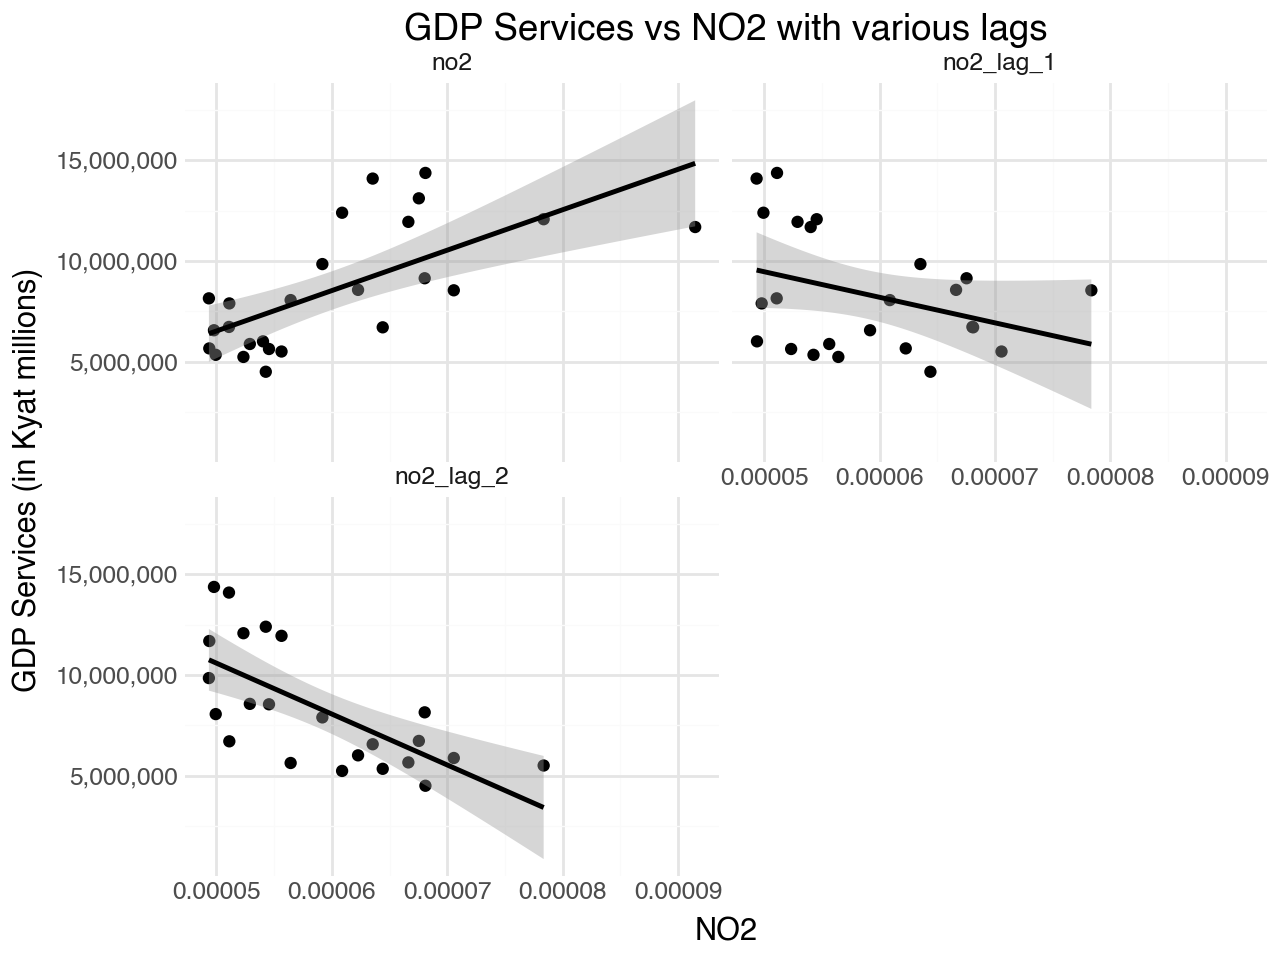

In [14]:
(
    no2_indicators.filter(["gdp_svc_lag_1", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_svc_lag_1", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_svc_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Services vs NO2 with various lags",
        x="NO2",
        y="GDP Services (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

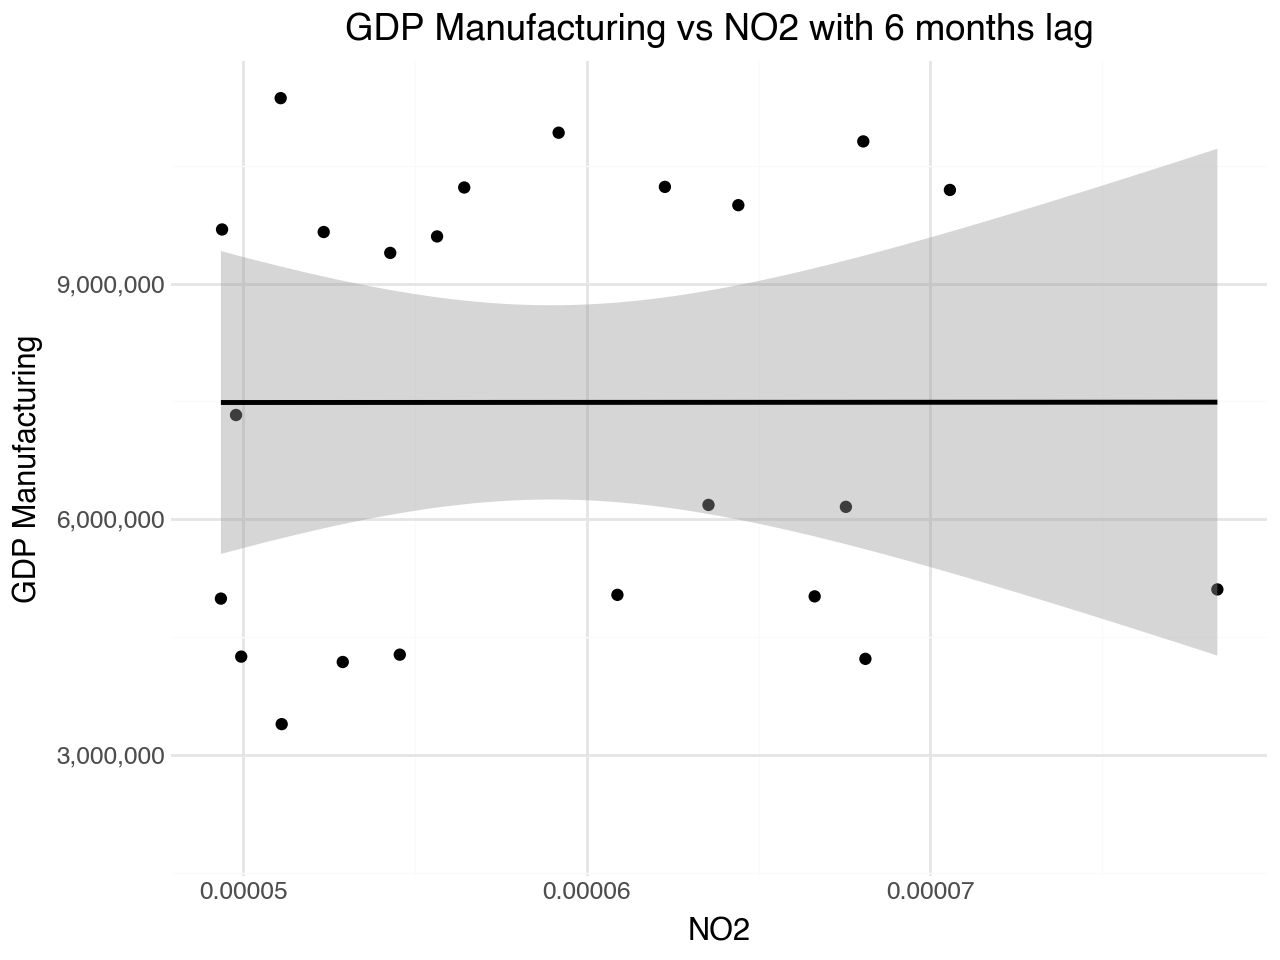

In [15]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_lag_2", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2 with 6 months lag",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

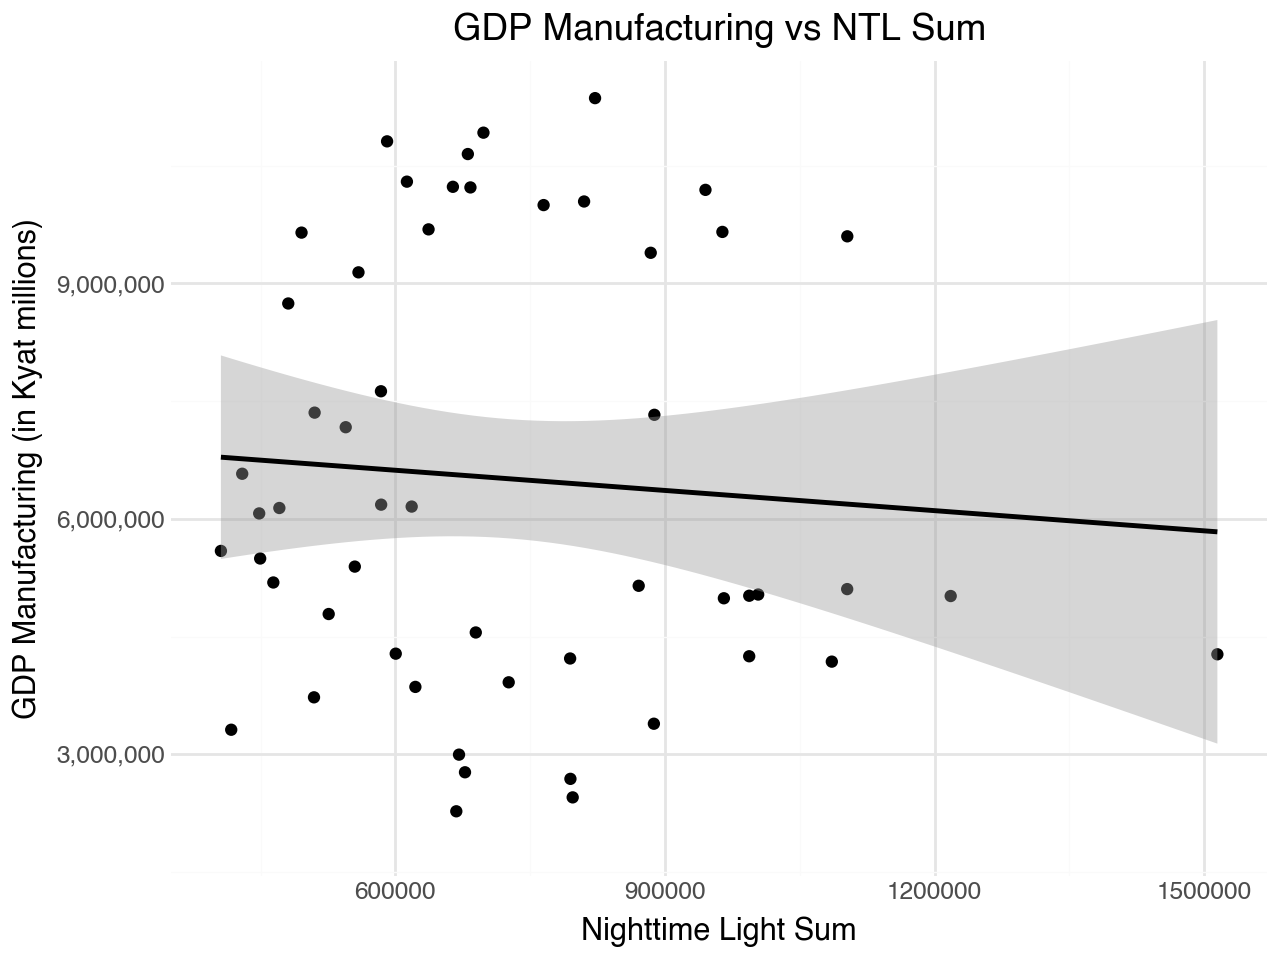

In [16]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.theme_minimal()
)

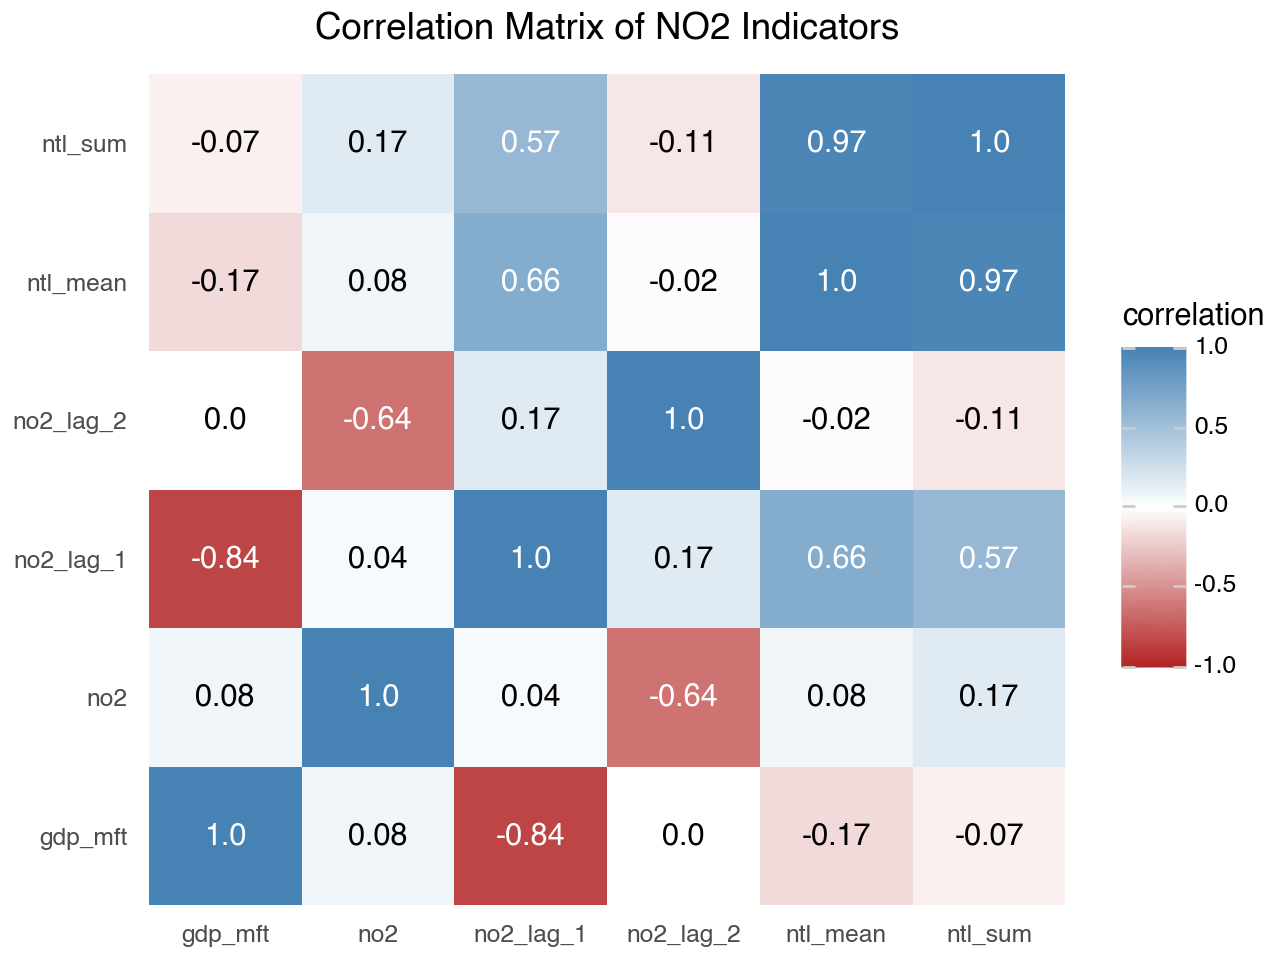

In [17]:
(
    no2_indicators.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of NO2 Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [18]:
mod_1 = smf.ols("gdp_mft ~ no2", data=no2_indicators).fit()
mod_2 = smf.ols("gdp_mft ~ ntl_mean + no2", data=no2_indicators).fit()
mod_3 = smf.ols(
    "gdp_mft ~ ntl_mean + no2 + no2_lag_1 + no2_lag_2", data=no2_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [21]:
mod_4 = smf.ols(
    "gdp_mft ~ ntl_mean_std + no2_std + no2_lag_1_std + no2_lag_2_std",
    data=no2_indicators,
).fit()

Stargazer([mod_4])

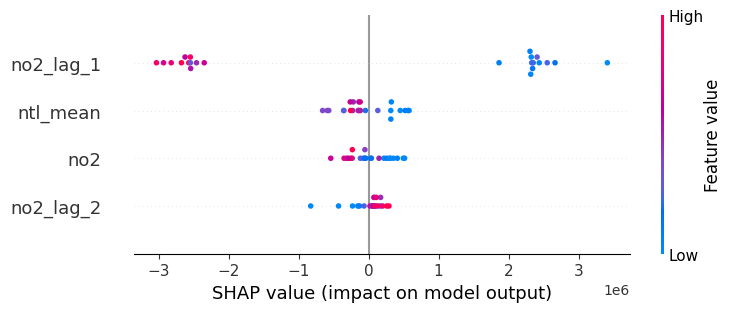

In [22]:
no2_indicators_clean = no2_indicators.dropna()
X = no2_indicators_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

In [23]:
no2_indicators_adm1 = (
    gdp_mft_quarterly_adm1.join(no2_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_mft_c=lambda df: df["gdp_mft"] - df["gdp_mft"].mean(),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            no2_lag_1=df["no2"].shift(1),
            no2_lag_2=df["no2"].shift(2),
            no2_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_1"]]
            ),
            no2_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_2"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

no2_indicators_adm1.tail()

gdp_mft  gdp_mft_lag_1  gdp_mft_lag_2       no2  \
adm1_name date                                                               
Yangon    2024-01-01  3.398282e+06   3.607797e+06   1.807322e+06  0.000117   
          2024-04-01  1.480224e+06   3.398282e+06   3.607797e+06  0.000078   
          2024-07-01  1.776077e+06   1.480224e+06   3.398282e+06  0.000053   
          2024-10-01  3.621611e+06   1.776077e+06   1.480224e+06  0.000083   
          2025-01-01  3.429651e+06   3.621611e+06   1.776077e+06  0.000126   

                      ntl_mean        ntl_sum     gdp_mft_c   no2_std  \
adm1_name date                                                          
Yangon    2024-01-01  1.288833  248295.662349  3.057078e+06  5.495263   
          2024-04-01  1.451145  178197.192109  1.139020e+06  1.962773   
          2024-07-01  1.254324  155936.478288  1.434873e+06 -0.351900   
          2024-10-01  1.215892  175752.381717  3.280407e+06  2.396172   
          2025-01-01  1.218102  176055.435025  3.088447e+06  6.361090   

                      ntl_mean_std  ntl_sum_std  no2_lag_1  no2_lag_2  \
adm1_name date                                                          
Yangon    2024-01-01      4.034178     5.218350   0.000084   0.000061   
          2024-04-01      4.611796     3.459408   0.000117   0.000084   
          2024-07-01      3.911372     2.900832   0.000078   0.000117   
          2024-10-01      3.774604     3.398061   0.000053   0.000078   
          2025-01-01      3.782467     3.405666   0.000083   0.000053   

                      no2_lag_1_std  no2_lag_2_std  ntl_mean_lag_1  
adm1_name date                                                      
Yangon    2024-01-01       0.373785      -0.842427        1.341484  
          2024-04-01       2.157060       0.380219        1.288833  
          2024-07-01       0.059193       2.129763        1.451145  
          2024-10-01      -1.315438       0.071578        1.254324  
          2025-01-01       0.316579      -1.277053        1.215892

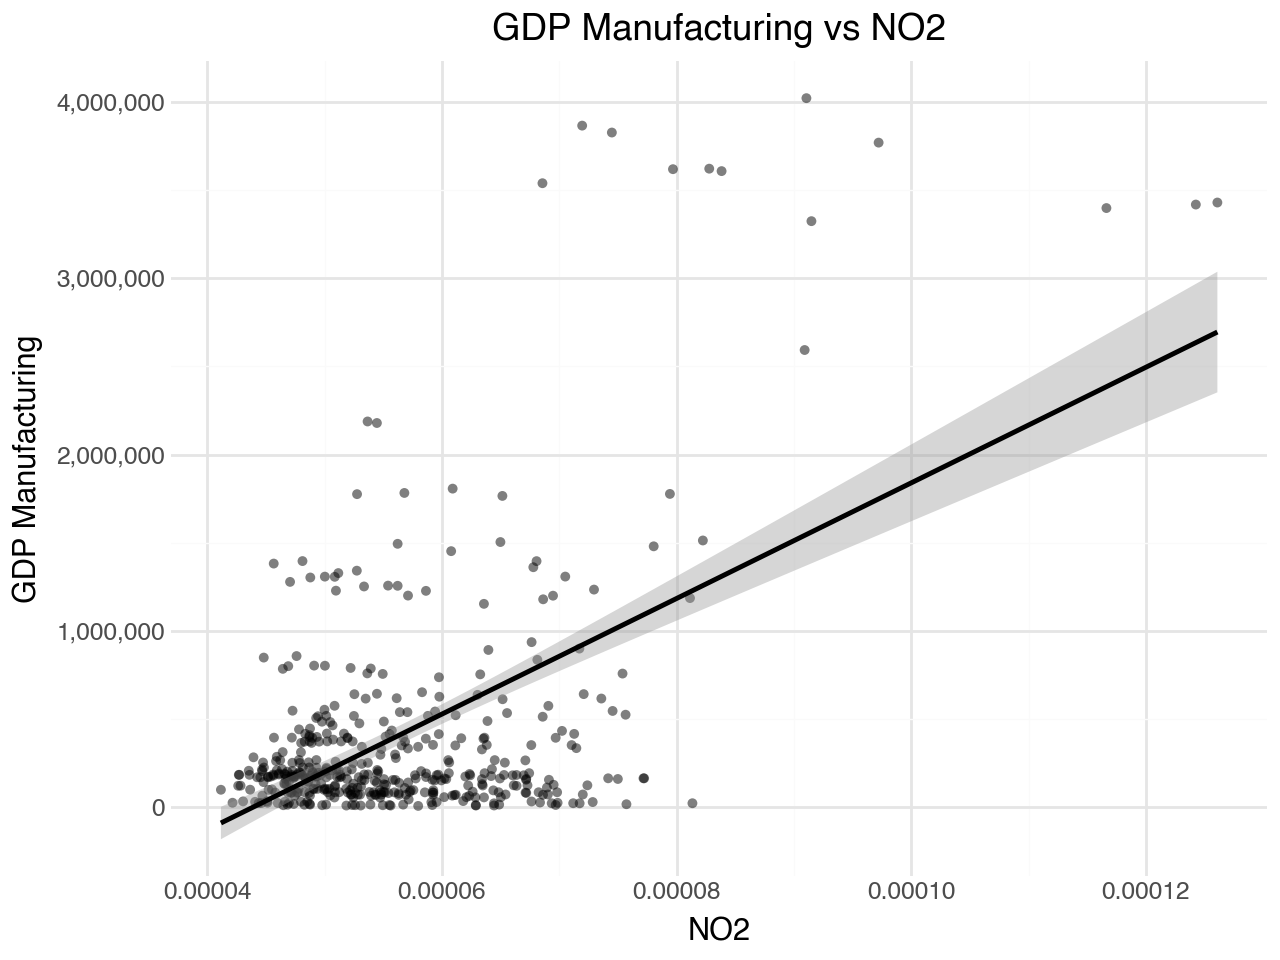

In [24]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

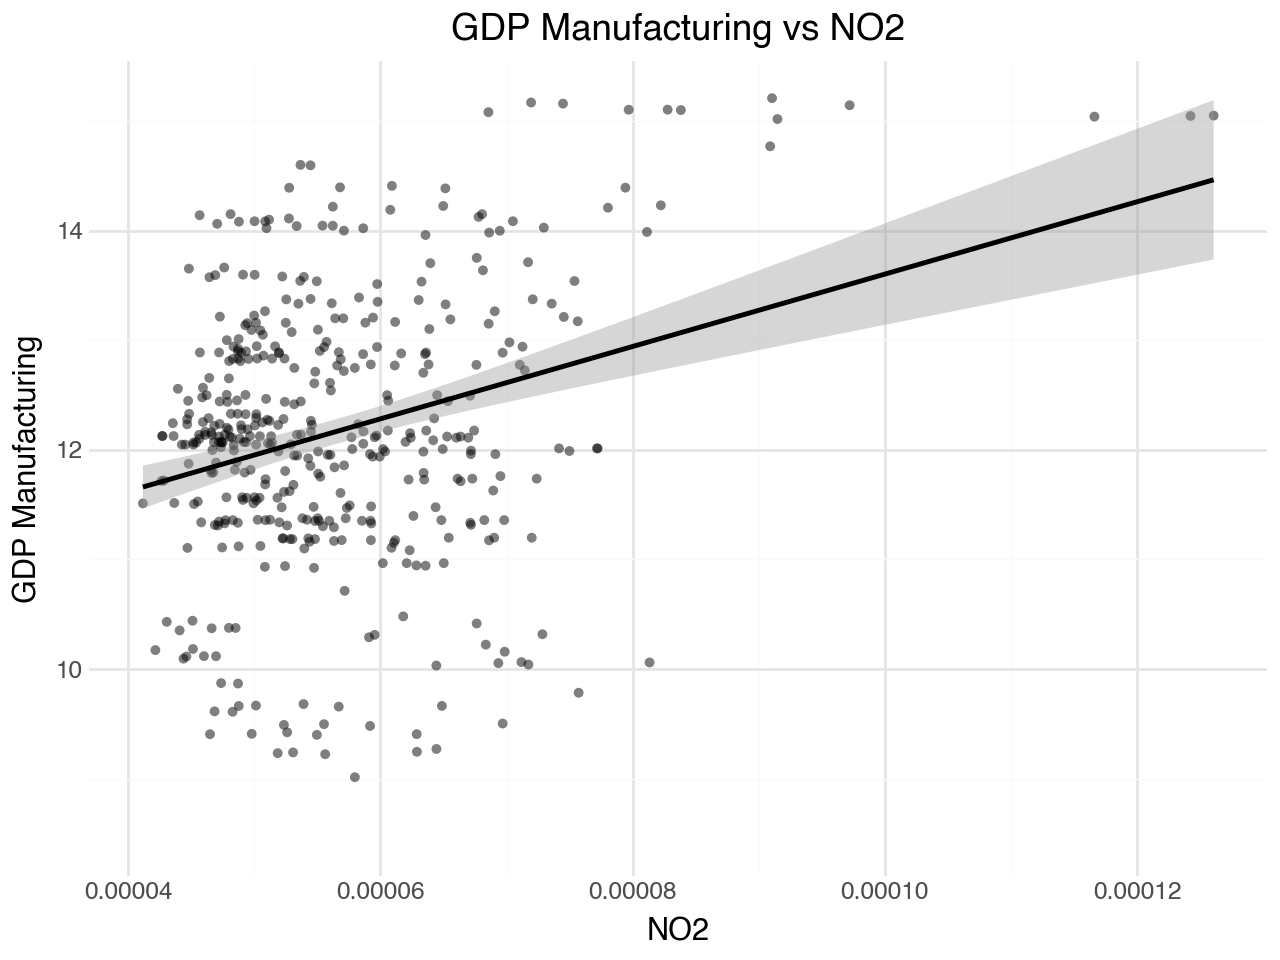

In [25]:
(
    no2_indicators_adm1.assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_mft_log=lambda df: np.log1p(df["gdp_mft"]),
    ).pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_mft_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

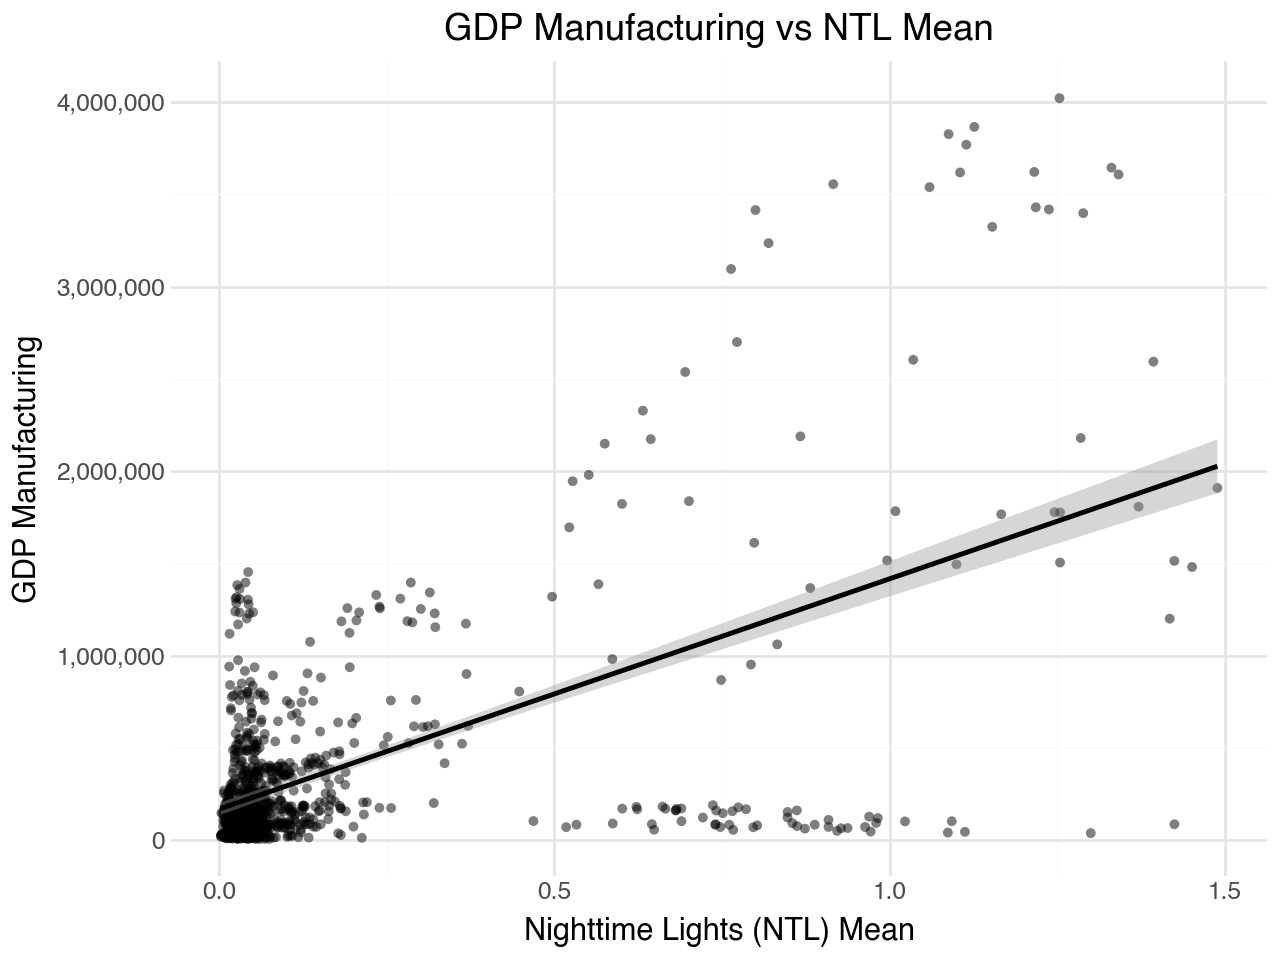

In [26]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

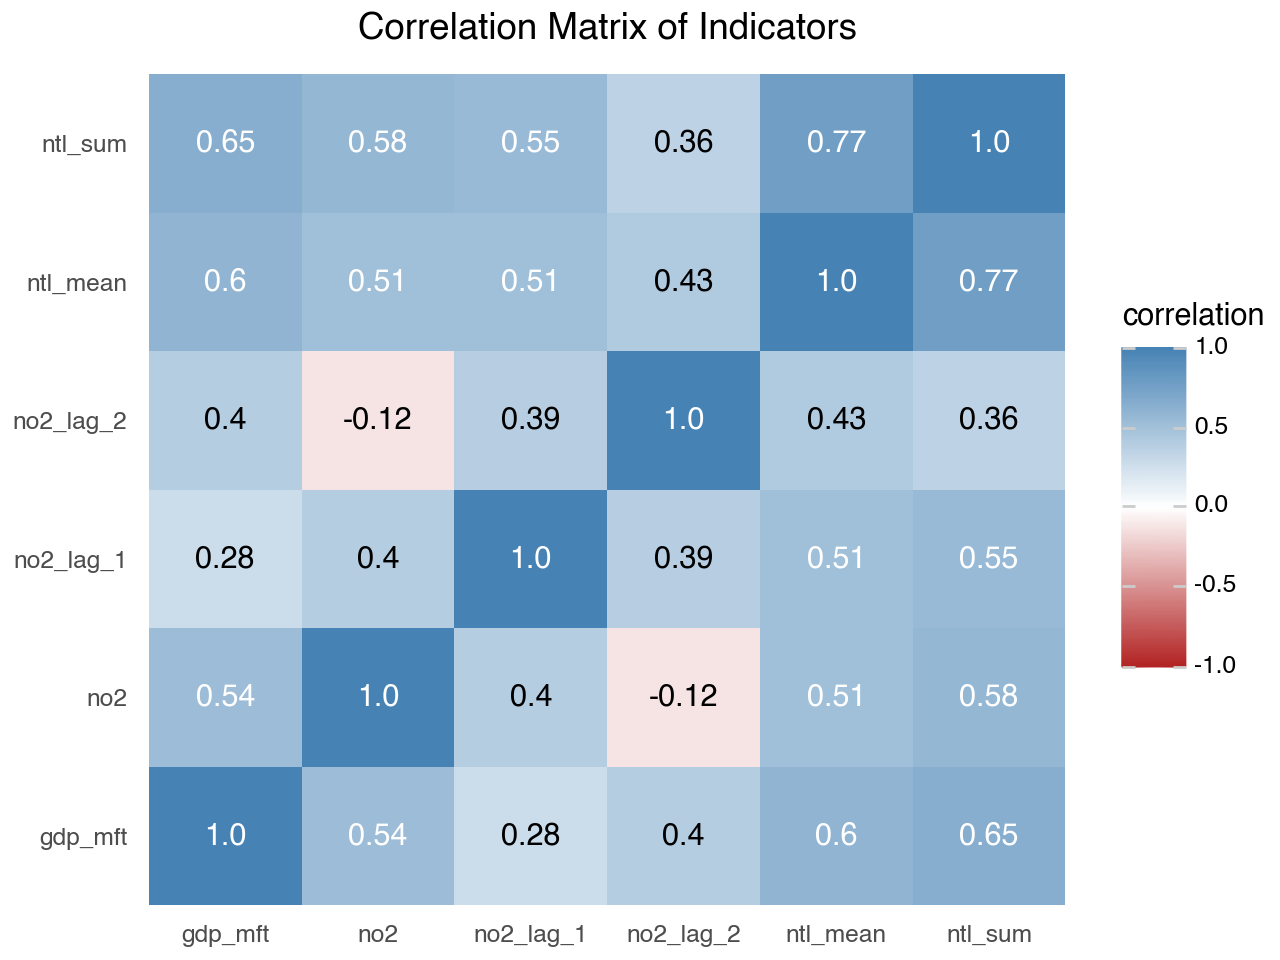

In [27]:
(
    no2_indicators_adm1.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [28]:
mod_3 = smf.ols(
    "np.log(gdp_mft) ~ np.log(ntl_sum) + np.log(no2)",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(gdp_mft)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     98.12
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           6.74e-36
Time:                        15:19:13   Log-Likelihood:                -638.69
No. Observations:                 438   AIC:                             1283.
Df Residuals:                     435   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.7182      3.696      0.465      0.642      -5.546       8.983
np.log(ntl_sum)     0.7969      0.064     12.359      0.000       0.670       0.924
np.log(no2)        -0.2185      0.338     -0.647      0.518      -0.882       0.445
==============================================================================
Omnibus:                       15.878   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.249
Skew:                          -0.347   Prob(JB):                      0.00133
Kurtosis:                       2.505   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
mod_3 = smf.ols(
    "gdp_mft ~ no2",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                gdp_mft   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     175.6
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           6.50e-34
Time:                        15:19:14   Log-Likelihood:                -6422.0
No. Observations:                 438   AIC:                         1.285e+04
Df Residuals:                     436   BIC:                         1.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.438e+06   1.43e+05    -10.082      0.000   -1.72e+06   -1.16e+06
no2         3.278e+10   2.47e+09     13.250      0.000    2.79e+10    3.76e+10
==============================================================================
Omnibus:                      207.580   Durbin-Watson:                   0.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1126.229
Skew:                           2.025   Prob(JB):                    2.77e-245
Kurtosis:                       9.731   Cond. No.                     9.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

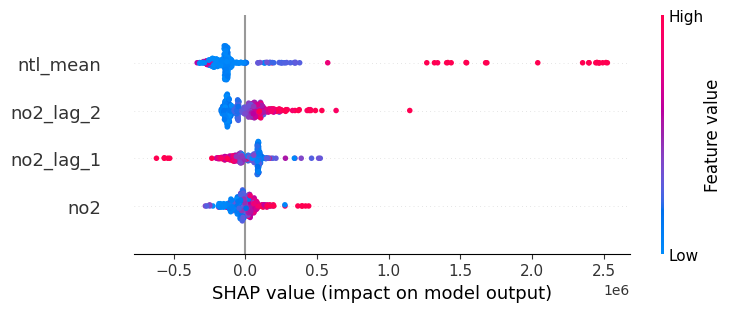

In [30]:
no2_indicators_adm_1_clean = no2_indicators_adm1.dropna()
X = no2_indicators_adm_1_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_adm_1_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)